In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
A set of popular optimizers in ML tweaked for approximating mathematical functions through SmoothL1Loss.
Created on Sun Nov 22 19:24:26 2020
@author: fguan
"""
from typing import Callable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
from torch import optim


def func(x):
    """ Function in R1."""
    return x ** 3 - x ** 2 + 2 * x

def funcR3(x, y):
    """ Function in R3."""
    return torch.sin(x * y)

def sgd(func: Callable, x: float, target: float, lr: float, iteration: int) ->\
        float:
    """ Standard gradient descent in R1.
    """
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    x = torch.tensor(x, requires_grad=True)
    for i in range(iteration):
        x = x.clone().detach().requires_grad_(True)
        loss = nn.MSELoss()
        loss = loss(func(x), target)
        loss.backward()
        ddx = x.grad
        x = x - ddx * lr
        plt.plot(i, abs(ddx.item()), 'ro')
    return x.item()

def sgd_m(func: Callable, x: float, target: float, lr: float, iteration: int, 
        b: float=0.9) -> float:
    """ Gradient descent of R1 function with momentum.
    """
    b = torch.tensor(b)
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    vx = torch.tensor(0.)
    x = torch.tensor(x, requires_grad=True)
    for i in range(iteration):
        x = x.clone().detach().requires_grad_(True)
        loss = nn.SmoothL1Loss()
        loss = loss(func(x), target)
        loss.backward()
        ddx = x.grad
        ddx = vx * b + (torch.tensor(1., requires_grad=True) - b) * ddx
        x = x - ddx * lr
        vx = ddx
        plt.plot(i, abs(ddx.item()), 'ro')
    return x.item()

def sgd_m_d(func: Callable, x: float, target: float, lr: float, iteration: int, 
       a: float=0.0001, b: float=0.9) -> float:
    """ Gradient descent of R1 function with momentum with lr decay.
    """
    a = torch.tensor(a)
    b = torch.tensor(b)
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    vx = torch.tensor(0.)
    x = torch.tensor(x, requires_grad=True)
    for i in range(iteration):
        x = x.clone().detach().requires_grad_(True)
        loss = nn.SmoothL1Loss()
        loss = loss(func(x),target)
        loss.backward()
        ddx = x.grad
        ddx = vx * b + (torch.tensor(1.) - b) * ddx
        lr = lr * torch.tensor(1.) / (torch.tensor(1.) + torch.tensor(i) * a)
        x = x - ddx * lr
        vx = ddx
        plt.plot(i, abs(ddx.item()), 'ro')
    return x.item()

def sgd_m_d_R3(funcR3: Callable, x: float, y: float, target: float, lr: float, 
    iteration: int, a: float=0.0001, b: float=0.9) -> float:
    """ Gradient descent in R3 space with momentum and lr decay.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    vx = torch.tensor(0.)
    vy = torch.tensor(0.)
    y = torch.tensor(y, requires_grad=True)
    x = torch.tensor(x, requires_grad=True)
    for i in range(iteration):
        x = x.clone().detach().requires_grad_(True)
        y = y.clone().detach().requires_grad_(True)
        ax.scatter(x.item(), y.item(), funcR3(x, y).item(), zdir='z', c='green',
                   s=20, depthshade=True)
        loss = nn.SmoothL1Loss()
        loss = loss(target, funcR3(x, y))
        loss.backward(retain_graph=True)
        ddx = x.grad
        ddy = y.grad
        ddx = vx * b + (torch.tensor(1.) - b) * ddx
        ddy = vy * b + (torch.tensor(1.) - b) * ddy
        lr = lr * torch.tensor(1.) / (torch.tensor(1.) + torch.tensor(i) * a)
        x = x - lr * ddx
        y = y - lr * ddy
        vx = ddx
        vy = ddy

    return x.item(), y.item()


def RMS_prop(func: Callable, x: float, target: float, lr: float,
        iteration: int, b=0.20, e=10**-8) -> float:
    """ RMS prop in R1.
    """
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    sx = 0 
    x = torch.tensor(x, requires_grad=True)
    for i in range(iteration):
        x = x.clone().detach().requires_grad_(True)
        loss = nn.SmoothL1Loss()
        loss = loss(func(x), target)
        loss.backward()
        ddx = x.grad
        ddx = ddx.item()
        sx = b * sx + (1 - b) * ddx ** 2
        plt.plot(i, sx, 'ro')
        x = x - lr * ddx /(e + (sx ** 0.5))
    return x.item()

def Adam(func: Callable, x: float, target: float, lr: float, iteration: int, 
         b1=0.9, b2=0.999, e=10**-8) -> float:
    """ Hard-coded ADAM algorithm in R1."""
    lr = torch.tensor(lr)
    target = torch.tensor(target)
    vx = 0
    sx = 0
    x = torch.tensor(x, requires_grad=True)
    for i in range(1, iteration + 1): 
        x = x.clone().detach().requires_grad_(True)
        loss = nn.SmoothL1Loss()
        loss = loss(func(x), target)
        loss.backward()
        ddx = x.grad
        ddx = ddx.item()
        vx = b1 * vx + (1. - b1) * ddx
        sx = b2 * sx + (1. - b2) * ddx ** 2
        v_corrected = vx / (1. - b1 ** i)
        s_corrected = sx / (1. - b2 ** i)
        plt.plot(i, loss.item(), 'ro')
        x = x - lr * v_corrected / (s_corrected  ** 0.5 + e)
    return x.item()

def adam_optim(func: Callable, x: float, target: float, lr: float, iteration: int):
    """ Torch built in ADAM."""
    lr = torch.tensor(lr)
    x = torch.tensor(x, requires_grad=True)
    target = torch.tensor(target)
    optimizer = optim.Adam([x], lr=lr)
    for i in range(iteration):
        optimizer.zero_grad()
        loss = (target - func(x)) ** 2
        loss.backward()
        plt.plot(i, loss.item(), 'ro')
        optimizer.step()
    return x.item()


0.5698402523994446

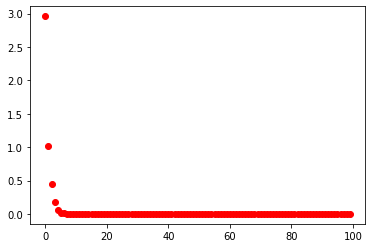

In [33]:
sgd(func, 0.1, 1.0, 0.1, 100)

In [31]:
func(0.5698402523994446)

0.9999999291918844

0.5683479905128479

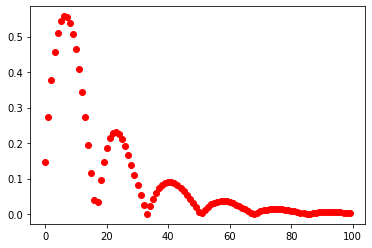

In [35]:
sgd_m(func, 0.1, 1.0, 0.1, 100)

0.5714274048805237

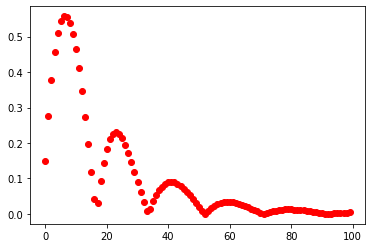

In [36]:
sgd_m_d(func, 0.1, 1.0, 0.1, 100)

(1.2272472381591797, 1.2113713026046753)

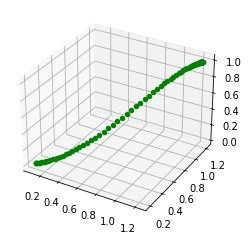

In [20]:
sgd_m_d_R3(funcR3, 0.1, 0.2, 1.0, 0.1, 100)

0.6169766783714294

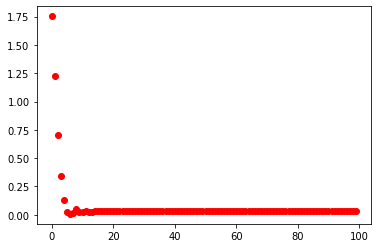

In [37]:
RMS_prop(func, 0.1, 1.0, 0.1, 100)

0.9986276626586914

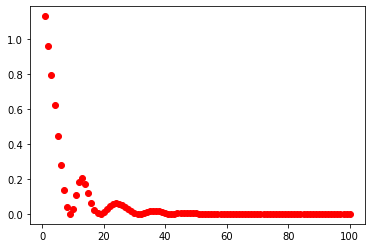

In [38]:
Adam(func, 0.2, 2.0, 0.1, 100)

1.0025238990783691

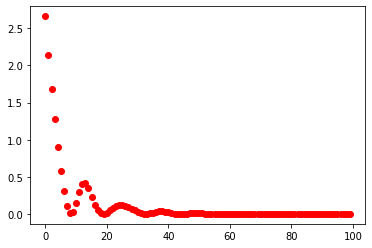

In [39]:
adam_optim(func, 0.2, 2.0, 0.1, 100)